In [ ]:
!pip install -U finance-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 772.1 kB/s eta 0:00:00


In [ ]:
# import library
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # 주가 데이터를 읽기 위해 Pandas 사용
import FinanceDataReader as fdr
import datetime as dt
from sklearn.model_selection import train_test_split

In [ ]:
now = dt.datetime.now().strftime('%Y-%m-%d')  # 오늘 날짜 기준

In [ ]:
df = fdr.DataReader('005930', end = now)

In [ ]:
display(df)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-02-10,5660,5880,5600,5760,1236979,NaN
2000-02-11,5960,5960,5680,5700,693257,-0.010417
2000-02-14,5600,5660,5340,5380,882889,-0.056140
2000-02-15,5380,5420,5140,5200,766393,-0.033457
2000-02-16,5180,5200,4780,5000,1462389,-0.038462
...,...,...,...,...,...,...
2024-05-28,76500,78000,76200,77600,18539072,0.005181
2024-05-29,77700,78200,75200,75200,30244875,-0.030928
2024-05-30,74800,75200,73500,73500,28551273,-0.022606


In [ ]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    1
dtype: int64

In [ ]:
df.iloc[0, 5] = 0 # NaN값 처리

In [ ]:
def MinMaxScaler(data): # 0 ~ 1 사이로 정규화
  min_val = data - np.min(data, 0)  # x - (x의 최솟값)
  max_val = np.max(data, 0) - np.min(data, 0) # (x의 최댓값) - (x의 최솟값)

  return min_val / max_val

In [ ]:
# 데이터 전처리
dfx = MinMaxScaler(df)

# 타겟변수
dfy = dfx[['Close']]  # 출력값

# 예측변수
dfx = dfx[['Open', 'High', 'Low', 'Volume', 'Change']] #입력값

x, y = dfx.values, dfy.values

In [ ]:
# 데이터를 시퀀스(시간 단위)로 나누기
x_data, y_data = [], []
input_length = 10 # 입력길이 = 10일간의 데이터
for i in range(len(x) - input_length):
  x_data.append(x[i:i + input_length])
  y_data.append(y[i + input_length])

In [ ]:
# train data:test data = 5:1
train_x = np.array(x_data[:5000], dtype = np.float32)
train_y = np.array(y_data[:5000], dtype = np.float32)

test_x = np.array(x_data[5000:], dtype = np.float32)
test_y = np.array(y_data[5000:], dtype = np.float32)

In [ ]:
# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units = 30, activation = 'tanh', input_shape = (input_length, 5)),
    tf.keras.layers.Dense(units = 1, activation = 'tanh')])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

epoch = 100
batch = 20

In [ ]:
# 모델 학습
train_data = model.fit(train_x, train_y, epochs = epoch, batch_size = batch, verbose = 1)
loss_val = train_data.history['loss'] # 손실값

# 모델 예측
pred_y = model.predict(test_x)

In [ ]:
# 예측 확인
pred_price = df.Close[-1] * pred_y[-1] / dfy.Close[-1]

print(f'실제 가격 : {df.Close[-1]}\n예측 가격 : {pred_price[0]:.2f}')

실제 가격 : 75700
예측 가격 : 68425.22


In [ ]:
# 스케일링된 데이터 원복
def restore_scaled_data(original_close, scaled_prediction, original_close_y):
    restored_value = original_close[-1] * scaled_prediction / original_close_y[-1]
    return restored_value

rest_pred_y = restore_scaled_data(df['Close'].values[-990:], pred_y, dfy['Close'].values[-990:])

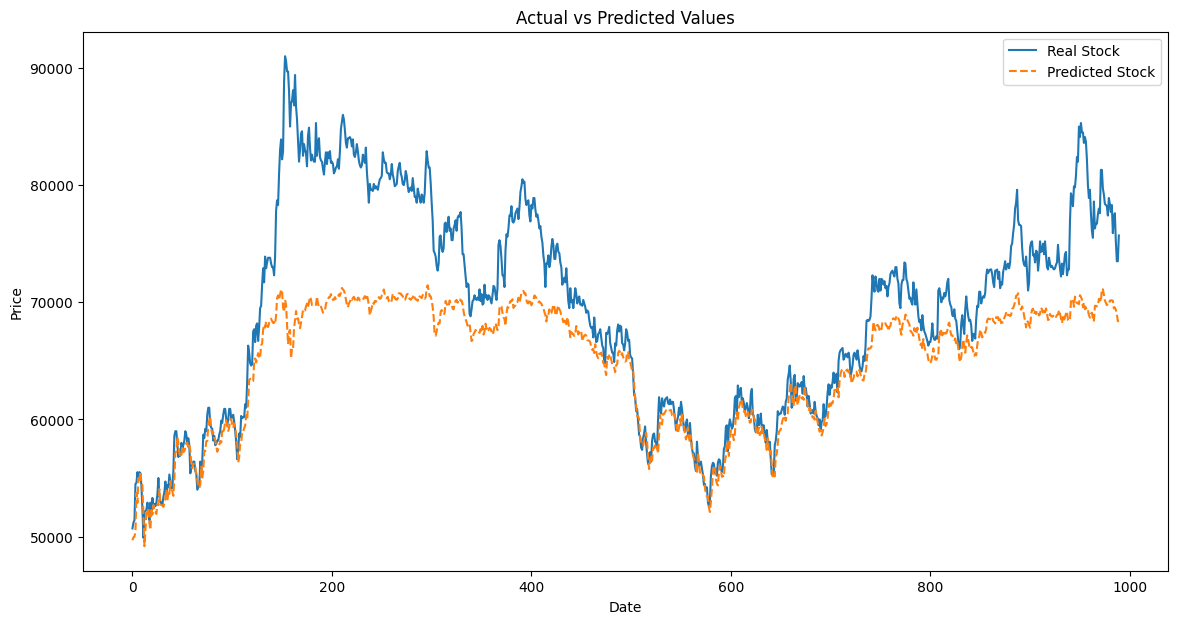

In [ ]:
# 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['Close'].values[-990:], label='Real Stock')
plt.plot(rest_pred_y, label='Predicted Stock', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Values')

plt.legend()
plt.show()

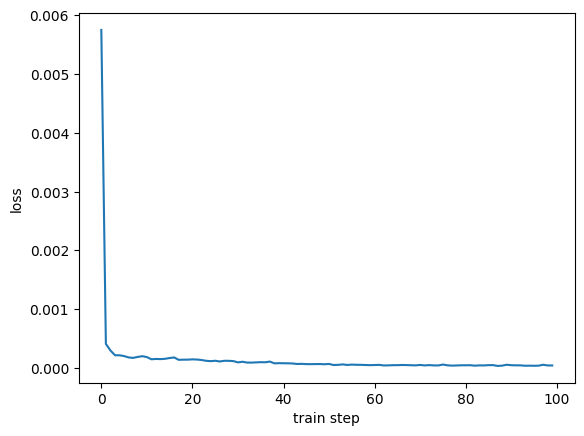

In [ ]:
plt.xlabel('train step')
plt.ylabel('loss')
plt.plot(loss_val)
plt.show()